# Melanoma analysis with fractal neural networks

This notebook shows how good is [Fractal neural network](#Fractal-neural-network) for [melanoma](#Melanoma) analysis.

In [1]:
import os
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Check if a GPU is available.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Remove excessive logging. 

In [3]:
tf.get_logger().setLevel('ERROR')

# Melanoma

__Melanoma__, also redundantly known as __malignant melanoma__, is a type of skin cancer that develops from the pigment-producing cells known as melanocytes. Melanomas typically occur in the skin, but may rarely occur in the mouth, intestines, or eye (uveal melanoma). In women, they most commonly occur on the legs, while in men, they most commonly occur on the back. About 25% of melanomas develop from moles. Changes in a mole that can indicate melanoma include an increase in size, irregular edges, change in color, itchiness, or skin breakdown.

![melanoma image](../assets/melanoma.jpg)

<div style="text-align: center; font-weight: bold">Pic.1. A melanoma of approximately 2.5 cm (1 in) by 1.5 cm (0.6 in)</div>

The primary cause of melanoma is ultraviolet light (UV) exposure in those with low levels of the skin pigment melanin. The UV light may be from the sun or other sources, such as tanning devices. Those with many moles, a history of affected family members, and poor immune function are at greater risk. A number of rare genetic conditions, such as xeroderma pigmentosum, also increase the risk. Diagnosis is by biopsy and analysis of any skin lesion that has signs of being potentially cancerous.

Melanoma is the most dangerous type of skin cancer. Globally, in 2012, it newly occurred in 232,000 people. In 2015, 3.1 million people had active disease, which resulted in 59,800 deaths. Australia and New Zealand have the highest rates of melanoma in the world. High rates also occur in Northern Europe and North America, while it is less common in Asia, Africa, and Latin America. In the United States, melanoma occurs about 1.6 times more often in men than women. Melanoma has become more common since the 1960s in areas mostly populated by people of European descent.

# Fractal neural network

We propose an ensemble model based on handcrafted fractal features and deep learning that consists of combining the classification of two CNNs by applying the sum rule. We apply feature extraction to obtain 300 fractal features from different
dermoscopy datasets. These features are reshaped into a 10 × 10 × 3 matrix to compose an artificial image that
is given as input to the first CNN. The second CNN model receives as input the correspondent original image.

![CNN image](../assets/fnn.png)

<div style="text-align: center; font-weight: bold">Pic.2. Overview of the proposed FNN model.</div>

If you want to learn more about fractal neural networks, read [here](https://www.sciencedirect.com/science/article/abs/pii/S0957417420308563).

## Dividing images into patches.

According to the acticle:
> One of the approaches available in the literature for multiscale analysis is the gliding-box algorithm (Ivanovici & Richard, 2011). The main advantage of this approach is that it can be applied on datasets containing images with different resolutions since the output features are given in relation to the scale instead of being absolute values. This algorithm consists in placing a box $\beta_{i}$ sized $𝐿 × 𝐿$ on the left superior corner of the image, wherein 𝐿 is given in pixels. This box glides through the image, one column and then one row at a time. After reaching the end of the image, the box is repositioned at the starting point and the value of 𝐿 is increased by 2.

The gliding-box method will not be used since it consumes too much RAM. We'll employ a box-counting approach, which basically means we'll partition the images into non-overlapping chunks.

In [4]:
class Patchify(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patchify, self).__init__()
        
        self.patch_size = patch_size
        
    def call(self, inputs):
        outputs = tf.image.extract_patches(
            inputs,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding='SAME'
        )
        
        _, rows, cols, _ = tf.unstack(tf.shape(outputs))
        outputs = tf.reshape(outputs, shape=(-1, rows * cols, self.patch_size, self.patch_size, 3))
        
        return outputs

## Creating an array of binary values from image patches using the Chebyshev colour distance function applied to the patch centre and each pixel.

According to the article:
> For each time the box $\beta_{i}$ is moved, a multidimensional analysis of colour similarity is performed for every pixel inside it. This is done by assigning the centre pixel to a vector $𝑓_{c} = 𝑟_{c}, 𝑔_{c}, 𝑏_{c}$, where $𝑟_{c}, 𝑔_{c}$ and $𝑏_{c}$ correspond to the colour intensities for each of the RGB colour channels of given pixel. The other pixels in the box are assigned to a vector $𝑓_{i} = 𝑟_{i}, 𝑔_{i}, 𝑏_{i}$ and compared to the centre pixel by calculating a colour distance $\Delta$. On the proposed approach, the Chebyshev ($\Delta_{h}$) ...

The following equation is used to compute the Chebyshev distance.

$$
\Delta_{h} = max(|f_{i}(k_{i}) - f_{c}(k_{c})|), k \in r, g, b. 
$$ 

In [5]:
class Chebyshev(tf.keras.layers.Layer):
    def __init__(self):
        super(Chebyshev, self).__init__()
        
    def call(self, inputs):
        batch_size, patch_number, patch_size, patch_size, channels = tf.unstack(tf.shape(inputs))
        outputs = tf.reshape(inputs, shape=(-1, patch_number, patch_size, channels))    
        
        centers = tf.image.resize_with_crop_or_pad(outputs, 1, 1)

        outputs = tf.math.subtract(outputs, centers)
        outputs = tf.math.abs(outputs)
        outputs = tf.math.reduce_max(outputs, axis=3)
        outputs = tf.math.less_equal(outputs, tf.cast(patch_size, dtype=tf.float32))
        outputs = tf.cast(outputs, dtype=tf.int32)
        outputs = tf.reshape(outputs, shape=(-1, patch_number, patch_size, patch_size))
        
        return outputs

## Creating an array of binary values from image patches using the Euclidean colour distance function applied to the patch centre and each pixel.

According to the article:
> For each time the box $\beta_{i}$ is moved, a multidimensional analysis of colour similarity is performed for every pixel inside it. This is done by assigning the centre pixel to a vector $𝑓_{c} = 𝑟_{c}, 𝑔_{c}, 𝑏_{c}$, where $𝑟_{c}, 𝑔_{c}$ and $𝑏_{c}$ correspond to the colour intensities for each of the RGB colour channels of given pixel. The other pixels in the box are assigned to a vector $𝑓_{i} = 𝑟_{i}, 𝑔_{i}, 𝑏_{i}$ and compared to the centre pixel by calculating a colour distance $\Delta$. On the proposed approach, ... the Euclidean ($\Delta_{e}$) ...

$$
\Delta_{e} = \sqrt{\sum_{k} (f_{i}(k_{i}) - f_{c}(k_{c}))^2}, k \in r, g, b
$$

In [6]:
class Euclidean(tf.keras.layers.Layer):
    def __init__(self):
        super(Euclidean, self).__init__()
        
    def call(self, inputs):
        batch_size, patch_number, patch_size, patch_size, channels = tf.unstack(tf.shape(inputs))
        outputs = tf.reshape(inputs, shape=(-1, patch_number, patch_size, channels))
        
        centers = tf.image.resize_with_crop_or_pad(outputs, 1, 1)

        outputs = tf.math.subtract(outputs, centers)
        outputs = tf.math.pow(outputs, 2)
        outputs = tf.math.reduce_sum(outputs, axis=3)
        outputs = tf.math.pow(outputs, 0.5)
        outputs = tf.math.less_equal(outputs, tf.cast(patch_size, dtype=tf.float32))
        outputs = tf.cast(outputs, dtype=tf.int32)
        outputs = tf.reshape(outputs, shape=(-1, patch_number, patch_size, patch_size))
        
        return outputs

## Creating an array of binary values from image patches using the Manhattan colour distance function applied to the patch centre and each pixel.

According to the article:
> For each time the box $\beta_{i}$ is moved, a multidimensional analysis of colour similarity is performed for every pixel inside it. This is done by assigning the centre pixel to a vector $𝑓_{c} = 𝑟_{c}, 𝑔_{c}, 𝑏_{c}$, where $𝑟_{c}, 𝑔_{c}$ and $𝑏_{c}$ correspond to the colour intensities for each of the RGB colour channels of given pixel. The other pixels in the box are assigned to a vector $𝑓_{i} = 𝑟_{i}, 𝑔_{i}, 𝑏_{i}$ and compared to the centre pixel by calculating a colour distance $\Delta$. On the proposed approach, ... the Manhattan ($\Delta_{m}$) ...

$$
\Delta_{m} = \sum_{k} |f_{i}(k_{i}) - f_{c}(k_{c})|, k \in r, g, b
$$

In [7]:
class Manhattan(tf.keras.layers.Layer):
    def __init__(self):
        super(Manhattan, self).__init__()
        
    def call(self, inputs):
        batch_size, patch_number, patch_size, patch_size, channels = tf.unstack(tf.shape(inputs))
        outputs = tf.reshape(inputs, shape=(-1, patch_number, patch_size, channels))
        
        centers = tf.image.resize_with_crop_or_pad(outputs, 1, 1)

        outputs = tf.math.subtract(outputs, centers)
        outputs = tf.math.abs(outputs)
        outputs = tf.math.reduce_sum(outputs, axis=3)
        outputs = tf.math.less_equal(outputs, tf.cast(patch_size, dtype=tf.float32))
        outputs = tf.cast(outputs, dtype=tf.int32)
        outputs = tf.reshape(outputs, shape=(-1, patch_number, patch_size, patch_size))
            
        
        return outputs

## Calculating probability matrices

According to the article:
> After performing this conversion for every box of every given 𝐿 scale, a structure known as probability matrix is generated. Each element of the matrix corresponds to the probability 𝑃 that 𝑚 pixels on a scale 𝐿 are labelled as 1 on each box. ... The matrix is normalized in a way that the sum of the elements in a column is equal to 1, as showed here:

$$
\sum_{m=1}^{L^2} P(m, L) = 1, \forall L
$$

In [8]:
class Probability(tf.keras.layers.Layer):
    def __init__(self):
        super(Probability, self).__init__()
        
    def call(self, inputs):
        batch_size, patch_number, patch_size, patch_size = tf.unstack(tf.shape(inputs))
        
        outputs = tf.math.reduce_sum(inputs, axis=(2, 3))
        outputs = tf.vectorized_map(lambda image: tf.math.bincount(image, minlength=patch_size ** 2 + 1), outputs)
        outputs = tf.math.divide(outputs, patch_number)        
        
        return outputs

## Calculating fractal dimensions

According to the article:
> FD is the most common technique to evaluate the fractal properties of an image. This is a measure for evaluating the irregularity and the complexity of a fractal. To obtain local FD features from the probability
matrix, for each value of 𝐿, the FD denominated 𝐷(𝐿) is calculated according to

$$
D(L) = \sum_{m=1}^{L^2} \frac{P(m, L)}{m}
$$

In [9]:
class FractalDimension(tf.keras.layers.Layer):
    def __init__(self):
        super(FractalDimension, self).__init__()
        
    def call(self, inputs):
        batch_size, _len = tf.unstack(tf.shape(inputs))
        numbers = tf.reshape(
            tf.concat(
                [tf.constant([1], dtype=tf.float32), tf.range(1, _len, dtype=tf.float32)], 
                axis=0
            ), 
            shape=(1, -1)
        )
        
        outputs = tf.math.divide(inputs, numbers)
        outputs = tf.math.reduce_sum(outputs, axis=1)
        
        return outputs

## Calculating lacunarity

According to the article:
> LAC is a measure complementary to FD and allows to evaluate how the space of a fractal is filled (Ivanovici & Richard, 2009). From the probability matrix, first and second-order moments are calculated with

$$
\mu(L) = \sum_{m=1}^{L^2} mP(m, L)
$$

$$
\mu^2(L) = \sum_{m=1}^{L^2} m^{2}P(m, L)
$$

> The LAC value for a scale $L$ is given by $\Lambda$(𝐿), which is obtained according to

$$
\Lambda(L) = \frac{\mu^{2}(L) - (\mu(L))^{2}}{(\mu(L))^{2}}
$$

In [10]:
class Lacunarity(tf.keras.layers.Layer):
    def __init__(self):
        super(Lacunarity, self).__init__()
        
    def call(self, inputs):
        batch_size, _len = tf.unstack(tf.shape(inputs))
        numbers = tf.reshape(
            tf.concat(
                [tf.constant([1], dtype=tf.float32), tf.range(1, _len, dtype=tf.float32)], 
                axis=0
            ), 
            shape=(1, -1)
        )
                
        mu_first_2 = tf.math.multiply(inputs, numbers)
        mu_first_2 = tf.math.reduce_sum(mu_first_2, axis=1)
        mu_first_2 = tf.math.pow(mu_first_2, 2)

        mu_second = tf.math.pow(numbers, 2)
        mu_second = tf.math.multiply(inputs, mu_second)
        mu_second = tf.math.reduce_sum(mu_second, axis=1)

        outputs = tf.math.divide(
            tf.math.subtract(mu_second, mu_first_2),
            mu_first_2
        )
        
        return outputs

## Calculating percolation Q - the average occurrence of percolation on a scale L

According to the article:
> We can also verify whether a box $\beta_{i}$ is percolating. This can be achieved due to a property that states a percolation threshold for different types of structures. In squared matrices (digital images), this threshold has the value of $p = 0.59275$, which means that if the ratio between pixels labelled as 1 and pixels labelled as 0 is greater or equal than $p$, the matrix is considered as percolating. Let $\Omega_{i}$ be the number of pixels labelled as 1 in a box $\beta_{i}$ with size $L \times L $ , we determine whether such box is percolating according to

$$
q_{i} = 
\begin{cases}
1, & \frac{\Omega_{i}}{L^2} \ge 0.59275 \\
0, & \frac{\Omega_{i}}{L^2} < 0.59275
\end{cases}
$$

> This results in a binary value for $q_{i}$, wherein 1 indicates that thebox is percolating. The feature $Q(L)$ regards the average occurrence of percolation on a scale $L$ and can be obtained by

$$
Q(L) = \frac{\sum_{i=1}^{T(L)} q_{i}}{T(L)}
$$

In [11]:
class PercolationQ(tf.keras.layers.Layer):
    def __init__(self, threshold=0.59275):
        super(PercolationQ, self).__init__()
        
        self.threshold = threshold
        
    def call(self, inputs):
        batch_size, patch_number, patch_size, patch_size = tf.unstack(tf.shape(inputs))
        
        outputs = tf.math.reduce_sum(inputs, axis=(2, 3))
        outputs = tf.math.divide(outputs, patch_size ** 2)
        outputs = tf.math.greater_equal(outputs, self.threshold)
        outputs = tf.cast(outputs, dtype=tf.float32)
        outputs = tf.math.reduce_mean(outputs, axis=1)
        
        return outputs

## Clustering values in binarized patches 

The next two layers, which calculate percolation C and M, work with value clusters. We clustorize values in a separate layer to speed up calculations.

In [12]:
class Clusterize(tf.keras.layers.Layer):
    def __init__(self):
        super(Clusterize, self).__init__()
        
    def call(self, inputs):
        batch_size, patch_number, patch_size, patch_size = tf.unstack(tf.shape(inputs))
        
        outputs = tf.reshape(inputs, shape=(-1, patch_size, patch_size))
        outputs = tfa.image.connected_components(outputs)
        outputs = tf.reshape(outputs, shape=(-1, patch_number, patch_size, patch_size))
        
        return outputs

## Calculating percolation C - the average number of clusters per box on a scale L

According to the article:
> Let $c_{i}$ be the number of clusters on a box $\beta_{i}$, the feature $C(L)$ that represents the average number of clusters per box on a scale $L$ is given by

$$
C(L) = \frac{\sum_{i=1}^{T(L)} c_{i}}{T(L)}
$$

In [13]:
class PercolationC(tf.keras.layers.Layer):
    def __init__(self):
        super(PercolationC, self).__init__()
        
    def call(self, inputs):
        outputs = tf.cast(inputs, dtype=tf.float32)
        outputs = tf.math.reduce_max(outputs, axis=(2, 3))
        outputs = tf.math.reduce_mean(outputs, axis=1)
        
        return outputs

## Calculating percolation M - the average coverage area of the largest cluster on a scale L

According to the article:
>Another feature that can be obtained is the average coverage area of the largest cluster in a box and is given by $M(L)$. Let $m_{i}$ be the size in pixels of the largest cluster of the box $\beta_{i}$. The feature $M(L)$ is givenaccording to

$$
M(L) = \frac{\sum_{i=1}^{T(L)} \frac{m_{i}}{L^2}}{T(L)}
$$

In [14]:
class PercolationM(tf.keras.layers.Layer):
    def __init__(self):
        super(PercolationM, self).__init__()
        
    def call(self, inputs):
        batch_size, patch_number, patch_size, patch_size = tf.unstack(tf.shape(inputs))
        
        outputs = tf.reshape(inputs, shape=(-1, patch_number, patch_size ** 2))
        outputs = tf.map_fn(lambda image: tf.math.reduce_max(tf.math.bincount(image)), outputs)
        outputs = tf.cast(outputs, dtype=tf.float32)
        
        return outputs

## Assembling fractal features into an image channel

According to the article:
> To serve as input for the incoming CNN classification, the feature vectors generated on the previous layers of the network must be converted into feature matrices. To do so, the 100 features obtained by each distance $\Delta$ are rearranged as a $10 \times 10 \times 10$ matrix. The matrices generated by $\Delta_{h}$, $\Delta_{e}$ and $\Delta_{m}$ correspond to the R, G and B colour channels, respectively. ... Since each of the functions $C(L), Q(L), M(L), \Lambda(L)$ and $D(L)$, obtained from a specific $\Delta$, generate 20 features, each function is fit exactly into 2 columns of the matrix.

>Since each of the functions $C(L), Q(L), M(L), \Lambda(L)$ and $D(L)$, obtained from a specific $\Delta$, generate 20 features, each function is fit exactly into 2 columns of the matrix.

In [15]:
class AssembleChannel(tf.keras.layers.Layer):
    def __init__(self):
        super(AssembleChannel, self).__init__()
        
    def call(self, inputs):
        fractal_dimension = tf.convert_to_tensor(inputs[0])
        fractal_dimension = tf.transpose(fractal_dimension, perm=(1, 0))
        
        lacunarity = tf.convert_to_tensor(inputs[1])
        lacunarity = tf.transpose(lacunarity, perm=(1, 0))
        
        percolation_q = tf.convert_to_tensor(inputs[2])
        percolation_q = tf.transpose(percolation_q, perm=(1, 0))
        
        percolation_c = tf.convert_to_tensor(inputs[3])
        percolation_c = tf.transpose(percolation_c, perm=(1, 0))
        
        percolation_m = tf.convert_to_tensor(inputs[4])
        percolation_m = tf.transpose(percolation_m, perm=(1, 0))
        
        outputs = tf.concat([
            percolation_c,
            percolation_q,
            percolation_m,
            lacunarity,
            fractal_dimension
        ], axis=1)
        outputs = tf.reshape(outputs, shape=(-1, 10, 10))
        
        return outputs

## Organising fractal feature extraction into layers

We move feature extraction to layers to simplify and clarify the code.

### based on Chebyshev distance

In [16]:
class ChebyshevFeatures(tf.keras.layers.Layer):
    def __init__(self):
        super(ChebyshevFeatures, self).__init__()
        
        self.chebyshev = Chebyshev()
        self.probability = Probability()
        self.clusterize = Clusterize()
        
        self.fractal_dimension = FractalDimension()
        self.lacunarity = Lacunarity()
        self.percolation_q = PercolationQ()
        self.percolation_c = PercolationC()
        self.percolation_m = PercolationM()
        
        self.assemble_channel = AssembleChannel()
        
    def call(self, inputs):
        chebyshevs = [self.chebyshev(i) for i in inputs]
        
        probability = [self.probability(ch) for ch in chebyshevs]
        cluster = [self.clusterize(ch) for ch in chebyshevs]
        
        fractal_dimension = [self.fractal_dimension(ch) for ch in probability]
        lacunarity = [self.lacunarity(ch) for ch in probability]        
        percolation_q = [self.percolation_q(ch) for ch in chebyshevs]
        percolation_c = [self.percolation_c(ch) for ch in cluster]
        percolation_m = [self.percolation_m(ch) for ch in cluster]
        
        features = self.assemble_channel([
            fractal_dimension,
            lacunarity,
            percolation_q,
            percolation_c,
            percolation_m
        ])
        
        return features

### based on Euclidean distance

In [17]:
class EuclideanFeatures(tf.keras.layers.Layer):
    def __init__(self):
        super(EuclideanFeatures, self).__init__()
        
        self.euclidean = Euclidean()
        self.probability = Probability()
        self.clusterize = Clusterize()
        
        self.fractal_dimension = FractalDimension()
        self.lacunarity = Lacunarity()
        self.percolation_q = PercolationQ()
        self.percolation_c = PercolationC()
        self.percolation_m = PercolationM()
        
        self.assemble_channel = AssembleChannel()
        
    def call(self, inputs):
        euclideans = [self.euclidean(i) for i in inputs]
        
        probability = [self.probability(eu) for eu in euclideans]
        cluster = [self.clusterize(eu) for eu in euclideans]
        
        fractal_dimension = [self.fractal_dimension(eu) for eu in probability]
        lacunarity = [self.lacunarity(eu) for eu in probability]        
        percolation_q = [self.percolation_q(eu) for eu in euclideans]
        percolation_c = [self.percolation_c(eu) for eu in cluster]
        percolation_m = [self.percolation_m(eu) for eu in cluster]
        
        features = self.assemble_channel([
            fractal_dimension,
            lacunarity,
            percolation_q,
            percolation_c,
            percolation_m
        ])
        
        return features

### based on Manhattan distance

In [18]:
class ManhattanFeatures(tf.keras.layers.Layer):
    def __init__(self):
        super(ManhattanFeatures, self).__init__()
        
        self.manhattan = Manhattan()
        self.probability = Probability()
        self.clusterize = Clusterize()
        
        self.fractal_dimension = FractalDimension()
        self.lacunarity = Lacunarity()
        self.percolation_q = PercolationQ()
        self.percolation_c = PercolationC()
        self.percolation_m = PercolationM()
        
        self.assemble_channel = AssembleChannel()
        
    def call(self, inputs):
        manhattans = [self.manhattan(i) for i in inputs]
        
        probability = [self.probability(mh) for mh in manhattans]
        cluster = [self.clusterize(mh) for mh in manhattans]
        
        fractal_dimension = [self.fractal_dimension(mh) for mh in probability]
        lacunarity = [self.lacunarity(mh) for mh in probability]        
        percolation_q = [self.percolation_q(mh) for mh in manhattans]
        percolation_c = [self.percolation_c(mh) for mh in cluster]
        percolation_m = [self.percolation_m(mh) for mh in cluster]
        
        features = self.assemble_channel([
            fractal_dimension,
            lacunarity,
            percolation_q,
            percolation_c,
            percolation_m
        ])
        
        return features

## Assembling fractal features into images

We assemble fractal features into images, such that each set of fractal features corresponds to a colour channel (R, G, B).

In [19]:
class AssembleImage(tf.keras.layers.Layer):
    def __init__(self):
        super(AssembleImage, self).__init__()
        
    def call(self, inputs):
        outputs = tf.stack(inputs)
        outputs = tf.transpose(outputs, perm=(1, 2, 3, 0))
        
        return outputs

## Organising the fractal feature extraction layers into the single, fractal image layer

To further simplify the code, we will gather the fractal feature extraction into the single layer, which generates artificial fractal image.

In [20]:
class FractalImage(tf.keras.layers.Layer):
    def __init__(self):
        super(FractalImage, self).__init__()
        
        self.patchifies = [Patchify(patch_size) for patch_size in range(3, 41 + 1, 2)]
        
        self.chebyshev_features = ChebyshevFeatures()
        self.euclidean_features = EuclideanFeatures()
        self.manhattan_features = ManhattanFeatures()
        
        self.assemble_image = AssembleImage()
        
    def call(self, inputs):
        patchifies = [patchify(inputs) for patchify in self.patchifies]
        
        chebyshev_features = self.chebyshev_features(patchifies)
        euclidean_features = self.euclidean_features(patchifies)
        manhattan_features = self.manhattan_features(patchifies)
        
        outputs = self.assemble_image([
            chebyshev_features,
            euclidean_features,
            manhattan_features
        ])
        
        return outputs

## Assembling the fractal neural network

So, here we are assembling the fractal neural network from the pieces mentioned above.

In [21]:
class FractalNeuralNetwork(tf.keras.Model):
    TARGET_WIDTH = 224
    TARGET_HEIGHT = 224
    
    def __init__(self, class_number):
        super(FractalNeuralNetwork, self).__init__()
        
        self.fractal_image = FractalImage()
        self.resize = tf.keras.layers.Resizing(width=self.TARGET_WIDTH, height=self.TARGET_HEIGHT)
        self.rescale_original = tf.keras.layers.Rescaling(scale=1./255)
        self.rescale_fractal = tf.keras.layers.Lambda(lambda x: tf.math.divide(x, tf.math.reduce_max(x)))
        self.mobilenet_v2 = hub.KerasLayer(
            "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
            output_shape=[1280], 
            trainable=False
        )
        self.combine = tf.keras.layers.Add()
        self.score = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        fractal_outputs = self.fractal_image(inputs)
        fractal_outputs = self.resize(fractal_outputs)
        fractal_outputs = self.rescale_fractal(fractal_outputs)
        fractal_outputs = self.mobilenet_v2(fractal_outputs)
        
        original_outputs = self.rescale_original(inputs)
        original_outputs = self.mobilenet_v2(original_outputs)
        
        outputs = self.combine([fractal_outputs, original_outputs])
        outputs = self.score(outputs)
        
        return outputs

# Data loading

## Data source

As a data source, we use the ISIC Archive.

The ISIC Archive is an open source platform with publicly available images of skin lesions under Creative Commons licenses. The images are associated with ground-truth diagnoses and other clinical metadata. Images can be queried using faceted search and downloaded individually or in batches. The initial focus of the archive has been on dermoscopy images of individual skin lesions, as these images are inherently standardized by the use of a specialized acquisition device and devoid of many of the privacy challenges associated with clinical images. To date, the images have been provided by specialized melanoma centers from around the world. The archive is designed to accept contributions from new sources under the Terms of Use and welcomes new contributors. There are ongoing efforts to supplement the dermoscopy images in the archive with close-up clinical images and a broader representation of skin types. The images in the Archive are used to support educational efforts through linkage with Dermoscopedia and are used for Grand Challenges and Live Challenges to engage the computer science community for the development of diagnostic AI.

For more information, go to [ISIC Archive web site](https://www.isic-archive.com/)

In [22]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.2, 1.5),
    validation_split=0.2,
)


training_set = generator.flow_from_directory(
    f"{os.environ['SCRATCH']}/data10000",
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    subset='training'
)
validation_set = generator.flow_from_directory(
    f"{os.environ['SCRATCH']}/data10000", 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    subset='validation'
)

Found 7881 images belonging to 9 classes.
Found 1964 images belonging to 9 classes.


In [23]:
CLASS_NUMBER = len(training_set.class_indices)

# Model training

## Preparing TensorFlow callbacks

For our convenience, we create a few TensorFlow callbacks.

### The TensorBoard callback

We want to see how the training is going. We add the callback, which will log the metrics to TensorBoard.

In [24]:
log_dir = '../logs/fit/' + datetime.datetime.now().strftime('fractalnet')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### The EarlyStopping callback

This callback stops training when the metrics (e.g. validation loss) are not improving,

In [25]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=3, 
    restore_best_weights=True
)

### The ModelCheckpoint callback

This callback saves the model with the best metrics during training.

In [26]:
checkpoint_path = 'checkpoints/fractalnet.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

## Actual training

In [27]:
model = FractalNeuralNetwork(class_number=CLASS_NUMBER)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=10,
    callbacks=[
        tensorboard_callback,
        early_stop_callback,
        checkpoint_callback
    ]
)

Epoch 1/10
247/247 [==============================] - ETA: 0s - loss: 0.6419 - accuracy: 0.8043 
Epoch 1: val_loss improved from inf to 0.53930, saving model to checkpoints/fractalnet.ckpt


247/247 [==============================] - 4958s 20s/step - loss: 0.6419 - accuracy: 0.8043 - val_loss: 0.5393 - val_accuracy: 0.8325
Epoch 2/10
247/247 [==============================] - ETA: 0s - loss: 0.5320 - accuracy: 0.8254 
Epoch 2: val_loss did not improve from 0.53930
247/247 [==============================] - 4873s 20s/step - loss: 0.5320 - accuracy: 0.8254 - val_loss: 0.5595 - val_accuracy: 0.8325
Epoch 3/10
247/247 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.8334 
Epoch 3: val_loss did not improve from 0.53930
247/247 [==============================] - 4989s 20s/step - loss: 0.5062 - accuracy: 0.8334 - val_loss: 0.5518 - val_accuracy: 0.8386
Epoch 4/10
247/247 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.8400 
Epoch 4: val_loss did not improve from 0.53930
247/247 [==============================] - 4785s 19s/step - loss: 0.4828 - accuracy: 0.8400 - val_loss: 0.6659 - val_accuracy: 0.8284


# Model validation

## Loading the model from the checkpoint

In [28]:
model = FractalNeuralNetwork(class_number=CLASS_NUMBER)
model.load_weights('./checkpoints/fractalnet.ckpt')

## Loading the test data

In [29]:
testing_set = generator.flow_from_directory(
    f"{os.environ['SCRATCH']}/data10000-test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 9843 images belonging to 9 classes.


## Making diagnoses

In [30]:
true_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [31]:
predicted_labels = model.predict(testing_set)

## Plot the ROC Curve

In [32]:
fpr = dict()
tpr = dict()
auc_metric = dict()

diagnosis_index_dict = {v: k for k, v in testing_set.class_indices.items()}

for i in range(CLASS_NUMBER):
    diagnosis = diagnosis_index_dict[i]
    fpr[diagnosis], tpr[diagnosis], _ = roc_curve(true_labels[:, i], predicted_labels[:, i])
    auc_metric[diagnosis] = auc(fpr[diagnosis], tpr[diagnosis])

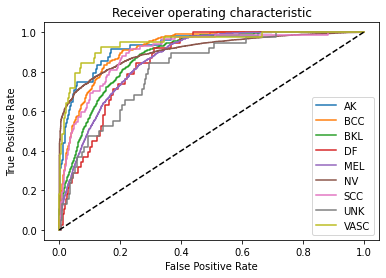

In [33]:
%matplotlib inline 
for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Show AUC

In [34]:
print(auc_metric)

{'AK': 0.9318019397651863, 'BCC': 0.919198382246189, 'BKL': 0.881696739344891, 'DF': 0.8550095278992996, 'MEL': 0.8644860714750129, 'NV': 0.9094890217141017, 'SCC': 0.9015646119089095, 'UNK': 0.8148527872460345, 'VASC': 0.9456344349245206}
